In [1]:
import re
from os import path
from time import time

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
7599,1559741070115840001,copa do mundo feminina sub- ⚽ converteu! goool...,1.244147,1
508985,1160685655833362439,- follow the profile and activate the notifica...,1.064913,1
364605,1559988907286171648,todas as vezes que tem jogo do flamengo lembro...,-0.146058,-1
559847,1160722556996988928,uhum sei prova ent 😌,0.484211,1
723163,1160987642764435457,se não for assim eu nem quero 💙,0.732456,1
789793,1161112103312338949,vou ir dormir 😴,-0.080780,-1
853839,1161279776168054784,como assim ??? 😂😂😂 estou parva para a minha vi...,0.883874,1
773189,1161073157161324545,vovo.ja. amam parabeisss 👍,0.522114,1
579982,1160746977690365952,aff vou ter que ir embora 💔,-0.121951,-1
365871,1559989425337155591,é vai ser no primeiro turno.🇧🇷🇧🇷🇧🇷👏👏👏💪💪💪,3.228784,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [substring for substring in string_tratada.split() if substring not in stopwords]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join([stemmer.stem(substring) for substring in string_tratada.split()])

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

16             de
47      estávamos
69            for
59    estivéramos
44          estas
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: dorme bem mô 💞

Tweet Limpo   : dorme bem mô

Tweet Stemed  : dorm bem mô


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
624568,1160846876737978368,silav. fatereşk:dalak. lê em ê li wateya penkr...,0.522114,1,silav fatereşk dalak lê ê li watey penkreas bi...
759672,1161051804785885185,eu to chorando pq meu irmão vai ter um baby bo...,0.732456,1,to chor pq irm vai ter baby boy sempr quil mãe...
449664,1160583479911997441,as espinhas voltaram com força 😪,-0.080913,-1,esp volt forç
534576,1160709463285948417,alguém pra apalpar minha peida? 😔,-0.146058,-1,alguém pra apalp peid
781553,1161091416233263105,a minha é incrível 💙,0.732456,1,incr


# Modelo Count Vectorizer

Este modelo utiliza uma matriz esparsa com a frequencia de cada palavra.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

### Count Vectorizer

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train["cleaned"])

CountVectorizer()

#### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [12]:
X_features_train = vectorizer.transform(X_train["cleaned"])
y_features_train = X_train["label"]

#### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [13]:
X_features_test = vectorizer.transform(X_test["cleaned"])
y_features_test = X_test["label"]

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [14]:
# Inicializar o Scaler
scaler = StandardScaler(with_mean=False)

# Treinar o Scaler
scaler.fit(X_features_train)

StandardScaler(with_mean=False)

In [15]:
# Transformar o conjunto de treinamento
X_features_train_scaled = scaler.transform(X_features_train)

In [16]:
X_features_test_scaled = scaler.transform(X_features_test)

# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [17]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 3.64%


In [18]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 11.62%


In [19]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 43.03%


In [20]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 43.03%


## Naive Bayes

Referências:
- [https://en.wikipedia.org/wiki/Naive_Bayes_classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

In [21]:
nb = MultinomialNB()

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [22]:
params = {
    "alpha": np.sort(np.append(np.linspace(0.5, 1.5, 20), 1)),
}

clf = RandomizedSearchCV(nb, params, n_iter=10, scoring="f1_weighted", n_jobs=-1, random_state=42)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 54.50%


In [23]:
clf.best_params_

{'alpha': 1.394736842105263}

In [24]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [25]:
print("Score Baseline : {:.2f}%".format(baseline_score*100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_*100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score-clf.best_score_)*100))

Score Baseline : 43.03%
Score Modelo   : 54.50%
Diferença      : 11.48%


### Performance no Conjunto de Treino

In [26]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 61.72%


### Curva de Aprendizado

In [27]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

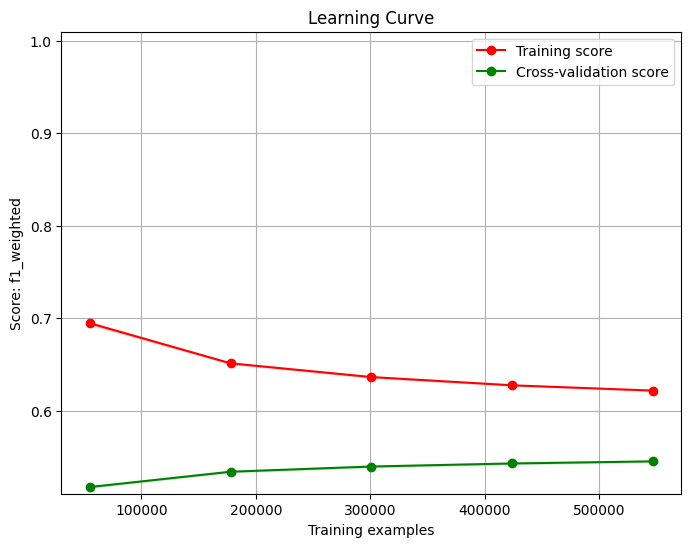

In [28]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Ada Boost

Referências:
- [https://en.wikipedia.org/wiki/AdaBoost](https://en.wikipedia.org/wiki/AdaBoost)
- [https://scikit-learn.org/stable/modules/ensemble.html#adaboost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

In [29]:
ada = AdaBoostClassifier(
    base_estimator=MultinomialNB(alpha=1.39),
    random_state=42,
)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [30]:
#params = {
#    "n_estimators": [int(x) for x in np.logspace(1, 2.6, 20)],
#    "learning_rate": np.sort(np.append(np.linspace(0.25, 5, 100), 1)),
#}

#clf = RandomizedSearchCV(ada, params, n_iter=10, scoring="f1_weighted", n_jobs=10, random_state=42)
#clf.fit(X_features_train_scaled, y_features_train)

#print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

In [31]:
#clf.best_params_
print("{'n_estimators': 12, 'learning_rate': 0.5378787878787878}")

{'n_estimators': 12, 'learning_rate': 0.5378787878787878}


In [32]:
#classifier = clf.best_estimator_

classifier = AdaBoostClassifier(
    base_estimator=MultinomialNB(alpha=1.39),
    n_estimators=12,
    learning_rate=0.5378,
    random_state=42,
)


scores = cross_val_score(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
ada_score = scores.mean()

print("F-Score: {:.2f}%".format(ada_score * 100))

F-Score: 60.03%


In [33]:
classifier.fit(X_features_train_scaled, y_features_train)

AdaBoostClassifier(base_estimator=MultinomialNB(alpha=1.39),
                   learning_rate=0.5378, n_estimators=12, random_state=42)

#### Comparação com Métrica base

In [50]:
print("Score Baseline : {:.2f}%".format(baseline_score*100))
print("Score Modelo   : {:.2f}%".format(ada_score*100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score-ada_score)*100))

Score Baseline : 43.03%
Score Modelo   : 60.03%
Diferença      : 17.01%


### Performance no Conjunto de Treino

In [35]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 65.88%


### Curva de Aprendizado

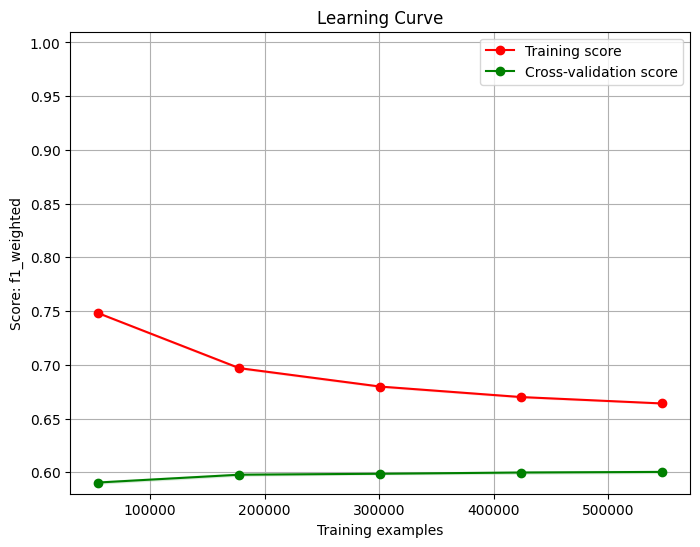

In [36]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Validação em conjunto de Teste

In [37]:
y_pred = classifier.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 60.13%


### Preditos Positivos

In [38]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [39]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['a juliana vai sair 😒',
       'se o desfile de de setembro for no quartel dnv eu penso seriamente em não participar 😔 mas sei que vou ser obrigada',
       'feio sim! 😩', 'kkk eu n tenho nem ideia ainda hsusgsuabsuah 😭😭',
       'cheguei agora da casa da fer, minha vontade era de ficar mais com ela lá 😩',
       'curitiba? 😔', 'muito bom dia, com aquela preguiça de garota 😴🥵',
       'o vai dar um tempo no canal 😞 ele pediu para continuarmos vigilantes até ele voltar.',
       'mas eu só jogo dia de sábado 😭😭😭',
       'as mentiradas no telegram e no zap dando algum resultado... 😒😒'],
      dtype=object)

#### Falso Positivo -> Neutro

In [40]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['estou fazendo strogonoff de carne 😅', 'faltou a gozada 🔥🤤',
       'eu tambem 😂 se ficar sozinha no quarto qualquer barulho me assusta',
       'trabalhei o dia todo, fui para o evento tá empresa, foi algo incrível, palestras e tudo mais, cheguei em casa agr, tô morto👎🏻 mas só agradecer por tudo🙏',
       'agora sim estou ansiosa...👀👀', 'obrigado 🔥',
       'faz tempo q n pego um fluxo q as pessoas perguntam se eu to namorando kkk sei sossegar c mh própria companhia, graças a deus 😅',
       'agora sim começa o meu ano. 😅', 'ksksks grita e nois tem muitos😂',
       'renatinho lima já tomou seu chimarrão, espero que ele tenha descido bem quentinho 😂'],
      dtype=object)

#### Verdadeiro Positivo

In [41]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['perfeição na terra 😍',
       'será que isso é real tbm? tá perfeito demais, eu podia ficar o dia inteiro na beira do mar assistindo isso!! ✌🏻❤️',
       'como não amar a dahyun? sempre sorrindo ❤', 'amém. 🙏',
       'bom diaa, renovado 💪',
       'quase torceu o pescoço e saiu rindo 😂 😂 😂', 'ele e pica 😂😂😂',
       'gratidão 😍',
       'realmente está espetacular! ainda bem que deu tempo para eu fotografar antes das pétalas cairem, 🙌…',
       'parabéns lela te amoo💗'], dtype=object)

### Preditos Negativos

In [42]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [43]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['🎶🎶eu querendo cortar laço ela querendo fazer nó.🎵🎵',
       'meu que foda, eu mal sei se a pessoa me quer por perto 👍',
       'honestidade sem empatia é crueldade ✨bom dia✨',
       'vim fazer um procedimento nos dentes e esqueci de comer direito.. agora vou ter que ficar com fome 🙌',
       'tomei a dose do covid, só dor agora😍',
       'eu perdi quase kg por estresse, trabalhar com bike e até mesmo, estar evitando comer gordura todo dia!.. mas tá sendo muito difícil recuperar esses kilinhos de forma saudável!!.. comprei até aveia!!kkk eu vou conseguir!! 💪💪',
       'pesadelo de pobre é morrer de tiro 🎶', 'amo éste tema de 💕',
       'os spoilers foram o máximo, a destruição se aproxima 🔥🔥🔥',
       'bateu o soninho, vou aproveitar antes q vá embora, tchau 💋'],
      dtype=object)

#### Falso Negativo -> Neutro

In [44]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['só oq eu preciso hj!! 😢',
       'estas depressões noturnas só se resolvem de uma maneira... à chandler! mas tenho que ter alguém com quem partilhar as piadas 😅',
       'a sensação de falta de ar é uma das piores que se pode sentir pqp 😥',
       'esse gerson parece eu qnd corto p meio 😅',
       'o sono faz falar à toa 😂',
       'indo pra minha consulta, agr vou deixar de ser uma fit de centavos \U0001f979😂',
       'me senti mal agora, eu sempre durmo umas h 😅',
       'mano que dor no meu coração 😢',
       'cada segundo q passa a preocupação aumenta mais 😰',
       'seria errado querer tomar uma cerveja hoje ? 😢'], dtype=object)

#### Verdadeiro Negativo

In [45]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['tô cheia de sono 😴', 'me estresso tao fácil, pqp 😒',
       'matemática foi ok agr falta química 😭',
       'eu não aguento mais notícia ruim, chega 😭',
       'to aqui no eng mais queria tá no jaca 😓',
       'opoxa, quando você instalar de novo me chama, aí jogamos juntos! 😞',
       'só pq eu não quero trabalha mais nesse ibiraci , aparece um trampo atrás do outro pra mim 😑 aceitar ou não , eis a questão !?',
       '😔 a vida é triste', 'tô com um mal estar 😓',
       'ai to passando mal 😖'], dtype=object)

### Preditos Neutros

In [46]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [47]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['peliculon... 👏💪👌', 'tô tentando apagar fogo c gasolina... 🎶',
       'ontem a minha sandra vez os convites po batizado do lourenço tao lindos 💙🥺',
       'algumas pessoas me perguntando o que eu fiz pra perder peso. passei por um de espadas e a torre, perdi kg em uma semana. não recomendo!😌',
       'vou entrar com um processo contra ela. ela chamou os carecas de cabeça de ovo. fiquei chocado 😁😁',
       'acho que ela quis me assustar, deve ser a algum componente. mas eu não bebo mesmo. 😊',
       'pra ir pra cadeia né drácula em falar nisso como está a construção do muro do méxico pra o brasil já fiscalizar se tem um dinheiro 💰💰💰💸💰 esperando vc lá pra tú e o pé de pinga mijado vagabundo 🤟🤘✌️😎👉👉',
       'quando era miúda e tinha aulas de dança era comum ver alguém sair mais tristonho se o professor não lhe tivesse dado uma única nota/correção durante a aula. sentiamo-nos invisíveis. se levantamos a questão é porque gostamos do belenenses e da académica. 💜',
       'manuela cis

#### Falso Neutro -> Negativo

In [48]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['minha mãe que arrumou uma infecção intestinal 😓',
       'eu tô com frio, aí calço meias quentinhas e pantufas. aí esquento os pés, eles suam, ficam gelados... ó, vida, ó azar... 😩',
       'e começou a rir porque eu não podia xingar ele de volta 😭😭😭 gringo filho da puta',
       'greve de ônibus, achei q teria aquela folguinha kkk uber 😑',
       'eu mereço um chororô desse sendo que nem tá no meio do rolo 😒',
       'nas asf😭😭',
       'assisto um ep de sintonia e outro de chernobyl kkk jaja termino as duas 😒',
       'o que foi esse quarto episódio de years and years? 😨 acho que nunca uma série me chocou tanto com um episódio',
       'meu amigo gringo é diabético e ficou anos pagando uma ambulância porque desmaiou de hipoglicemia no cinema... 😔 eu fico de cara com essas histórias, país neoliberal podre',
       'amboi porn!! 😠'], dtype=object)

#### Verdadeiro Neutro

In [49]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['sou louca pra ficar ctg, tem vez que eu passo na rua e tu fica olhando 👀 — kkk brinca muito',
       'o cm da revista deixou o twitt programado sen ter tomado un café antes e claro, pasan estas cousas 😂',
       'se já usou as almas e subiu nível vai sem medo de morrer, o que vier depois é sempre lucro e se estiver morrendo muito, sebo nas canelas até a próxima fogueira 🔥 sem pensar duas vezes hehe',
       'botafogo é mesmo uma surpresa, não imaginava isso 😅 anyway vou fazer :q',
       'fiquei curioso, ficaram sem assunto no meio do encontro? 😂🤣',
       'não queria reclamar, mas como já é o terceiro riolu que choca, podia vir um cherubi da próxima vez, né? 😅 só falta…',
       'não.. cara. é a característica do signo. hahaha eu só faço merda mermo. 😂',
       'o erro do jovem é entrar no twitter na aula (tenho medo do que aparece na minha timeline😰😰) kakaka',
       'e isso decididamente não te impede de ser lulopet. 😂',
       'nao ne, vai que ela posta mais indireta no twi